In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import a list of top 20 cities in the US to be used in the API call below 
import xlrd
workbook = xlrd.open_workbook('/list_of_largest_cities_of_us-753j.xlsx') 
sheet = workbook.sheet_by_index(0)
List_big_cities = []
for row in range(1,sheet.nrows):
    List_big_cities.append(sheet.cell_value(row,0))

In [4]:
#Search API call to get business ID details
import requests
app_id = 'xxxxxxxxxxxx'
app_secret = 'xxxxxxxxxxxxxxxxxxxxxxxxxx'
data = {'grant_type': 'client_credentials',
        'client_id': app_id,
        'client_secret': app_secret}
business_id=[]
#POST to get access token details
token = requests.post('https://api.yelp.com/oauth2/token', data=data)
access_token = token.json()['access_token']

#Creating list of ~1000 restaurants per price segment
for cities in List_big_cities:
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': 'bearer %s' % access_token}
    params = {'location': cities,
              'term': 'restaurants',
              # price of 1,2,3 and 4 indicate $,$$,$$$ and $$$$ respectively. 
              # .. for each segment, price was edited and code was rerun.
              'price': '1',
              # Yelp has a limit of maximum 50 business results return
              'limit':50
             }

    resp = requests.get(url=url, params=params, headers=headers)
    pricey_business=resp.json()
    
    #creating list of relevant business IDs for Review API call
    for business in pricey_business['businesses']:
        business_id.append(business['id'])

In [5]:
print(len(business_id))

1000


In [6]:
#Review API call to obtain review text
review_text = ""
for business in business_id:
    options = '%s/reviews' % business
    business_url = 'https://api.yelp.com/v3/businesses/' + options
    headers = {'Authorization': 'bearer %s' % access_token}
    resp = requests.get(url=business_url, headers=headers)
    try:
        review = resp.json()
        for review in review['reviews']:
            review_text = review_text+(review['text'])           
    except Exception:
        pass

#Splitting review text and removing punctuations and changing words to lower case
import string
lower_list_words = []
list_words=review_text.split()
for i in range(len(list_words)):
    for c in string.punctuation:
        list_words[i]=list_words[i].replace(c,"")
        list_words[i]=list_words[i].replace('”',"")
        list_words[i]=list_words[i].replace('“',"")
        list_words[i]=list_words[i].replace('—',"")
        list_words[i]=list_words[i].replace('’',"")
        list_words[i]=list_words[i].replace('‘',"")
for i in list_words:
    lower_list_words.append(i.lower())
#print(lower_list_words)

In [7]:
#Remove STOPWORDS and perform word Lemmatization (conversion to base word) using Natural Language ToolKit package
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stopword_removed_verbified=[]
#nltk.download()
for i in range(len(lower_list_words)):
    if lower_list_words[i] not in stopwords.words('english'):
        #Lemmatization of words
        #print(lower_list_words[i],WordNetLemmatizer().lemmatize(lower_list_words[i],'v'))
        stopword_removed_verbified.append(WordNetLemmatizer().lemmatize(lower_list_words[i],'v'))
        
#print(stopword_removed_verbified)

In [22]:
#Find frequency of words
#this block of code is written to have a general understanding of most frequently used words for creation of word corpus...
#...this is not used for word cloud generation
word_count = dict()

for i in stopword_removed_verbified:
    if i in word_count:
        word_count[i]=word_count[i]+1
    else:
        word_count[i]=1
import operator 
sorted_word = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)

#for word in sorted_word:
    #print(word)
    

In [9]:
#Algorithm to perform spelling correction of typed review word
#Used minimum edit distance algorithm

#Cost associated with 1 substitution
def substCost(x,y):
    if x == y:
        return 0
    else:
        return 2

#Cost associated with 1 insertion
def insertCost(x):
    return 1

#Cost associated with 1 deletion
def deleteCost(x):
    return 1

##Computes the min edit distance from target to source
def  minEditDist(target, source):
    
    target=target.lower()
    source=source.lower()
    n = len(target)
    m = len(source)
    distance = []
 
    for i in range(n+1):
        temp = []
        for j in range (m+1):
            temp.append(0)
        distance.append(temp)

    for i in range(1,n+1):
        distance[i][0] = distance[i-1][0] + insertCost(target[i-1])

    for j in range(1,m+1):
        distance[0][j] = distance[0][j-1] + deleteCost(source[j-1])

    for i in range(1,n+1):
        for j in range(1,m+1):
            distance[i][j] = min(distance[i-1][j]+1,
                                distance[i][j-1]+1,
                                distance[i-1][j-1]+substCost(source[j-1],target[i-1]))
    return distance[n][m]

#minEditDist("really","regally")

In [11]:
#importing list of words in the word corpus created. Word Corpus contains ~2000 words relevant to food industry
import xlrd
workbook = xlrd.open_workbook('/Food Industry words.xlsx') 
sheet = workbook.sheet_by_index(0)
List_Positive_Words = []
for row in range(1,sheet.nrows):
    List_Positive_Words.append(sheet.cell_value(row,0).lower())

In [23]:
#cleaning spelling mistakes using minimum edit distance algorithm
word_cloud = []    
for i in range(len(stopword_removed_verbified)):
    for j in range(len(List_Positive_Words)):
        score = minEditDist(stopword_removed_verbified[i],List_Positive_Words[j])
        #score of 1 used to as limit
        #...word is replaced only in scenarios where one deletion or addition change source word to target
        #...used for error minimization
        if score==1:
            #print(stopword_removed_verbified[i],List_Positive_Words[j])
            stopword_removed_verbified[i] = List_Positive_Words[j]
            break

#creating a list of words based on food industry word corpus to be fed into word cloud
for i in range(len(stopword_removed_verbified)):
    if stopword_removed_verbified[i] in List_Positive_Words:
        word_cloud.append(stopword_removed_verbified[i])

Populating the interactive namespace from numpy and matplotlib


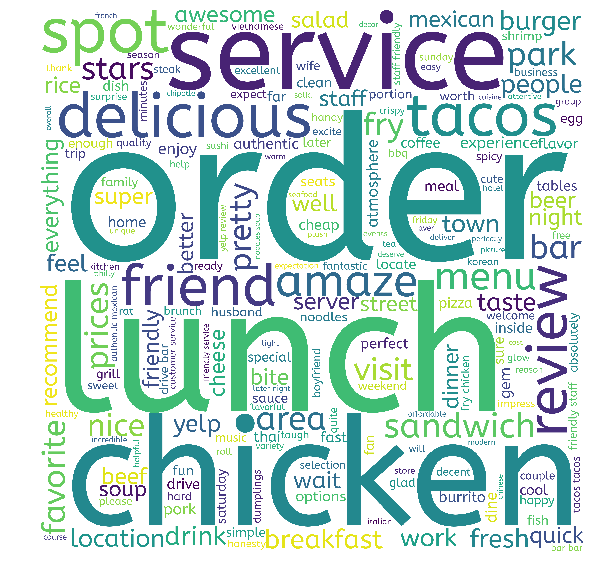

In [27]:
%pylab inline

#creation of word cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
significant_word =""
word_counts=[]
for i in range(len(word_cloud)):
    significant_word=significant_word+" "+word_cloud[i]

    
wordcloud = WordCloud(font_path='/ABeeZee-Regular.otf',
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=5000,
                          height=5000
                         ).generate(significant_word)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
fig = plt.gcf()
plt.axis('off')
plt.show()
fig.savefig("seg1.png")